# Load data

In [1]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


In [2]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()
sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']

# Read weights.txt helper
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# Load healthy weights
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Collect all sample data into a flat DataFrame
rows = []

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    weight_file = folder / "weights.txt"
    current_weights = read_weights(weight_file) if weight_file.exists() else {}

    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            # Load data
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

            # Delta weight
            delta_weight = current_weights.get(sample_file, None)
            if sample_file in healthy_weights and delta_weight is not None:
                delta_weight -= healthy_weights.get(sample_file, 0.0)

            # Store each row with metadata
            for _, row in df.iterrows():
                row_data = row.to_dict()
                row_data['folder'] = folder_name
                row_data['sample_file'] = sample_file
                row_data['delta_weight'] = delta_weight
                rows.append(row_data)

# Final DataFrame for easy analysis
combined_data = pd.DataFrame(rows)


# PLOT DATA

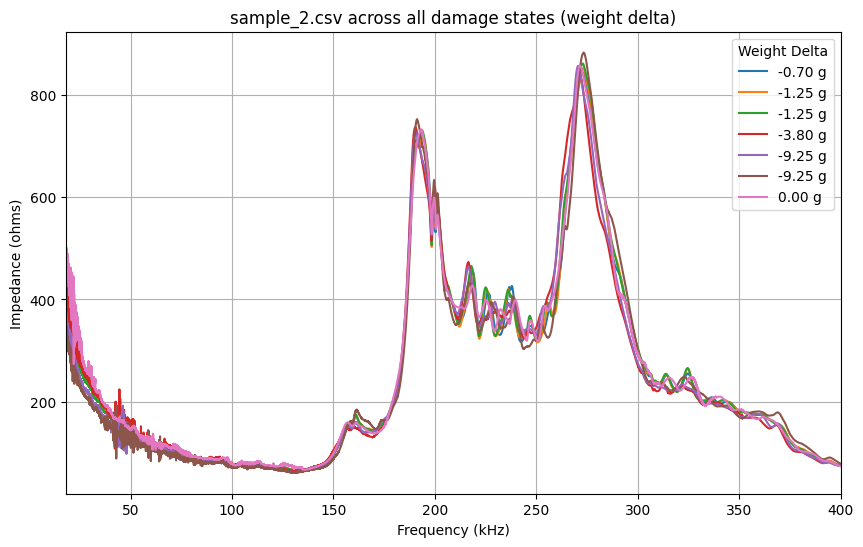

In [3]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_2.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Impedance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()



# RMSD function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rmsd_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Impedance (ohms)"].values[mask])

    rmsd_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Impedance (ohms)"].values[mask])
        rmsd = np.sqrt(np.mean((Z - Z_ref) ** 2))
        rmsd_list.append(rmsd)
        plt.plot(freqs_kHz, Z, label=str(label[i]))


    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Impedance")
    plt.title("Normalized Impedance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(rmsd_list)


## Test RMSD

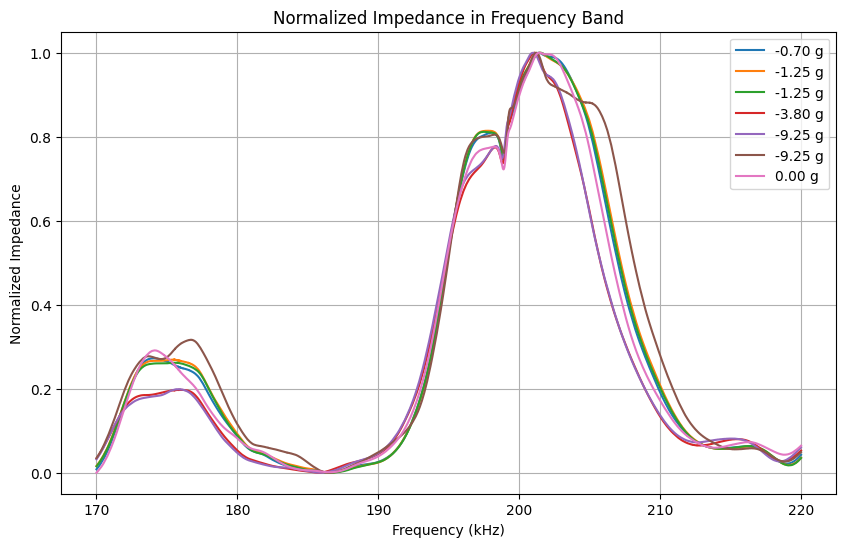

[0.02173932 0.03152481 0.02768094 0.04741285 0.04808134 0.07457356
 0.        ]


In [181]:
sample_to_plot = "sample_1.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(rmsd_values)

# CCD Function

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def compute_corr_dev_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Impedance (ohms)"].values[mask])

    corr_dev_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Impedance (ohms)"].values[mask])
        corr_coef = np.corrcoef(Z, Z_ref)[0, 1]  # Pearson correlation coefficient
        corr_dev = 1 - corr_coef
        corr_dev_list.append(corr_dev)
        plt.plot(freqs_kHz, Z, label=str(label[i]))

    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Impedance")
    plt.title("Normalized Impedance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(corr_dev_list)

## Test CCD Function

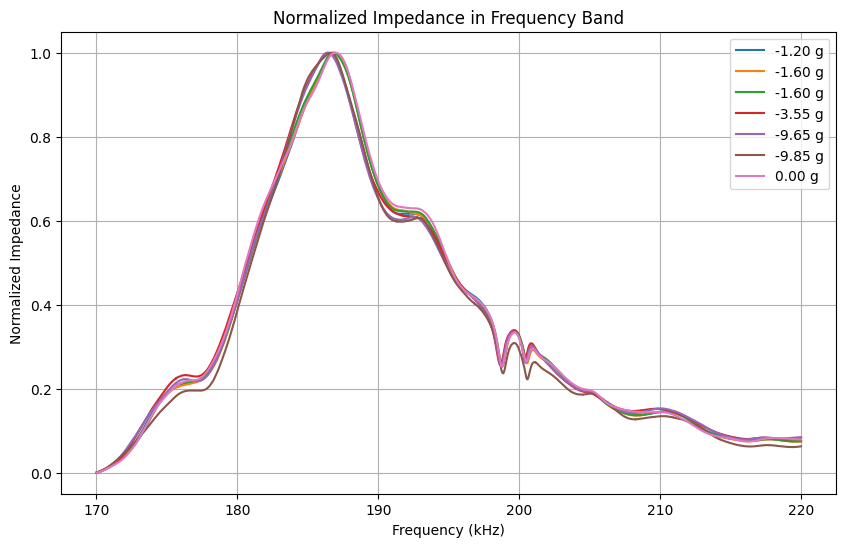

[3.58512397e-04 2.98855714e-04 3.75946416e-04 2.05212775e-03
 2.27481207e-03 2.59802349e-03 2.22044605e-16]


In [97]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(CCD_values)

# Get RMSD and CCD

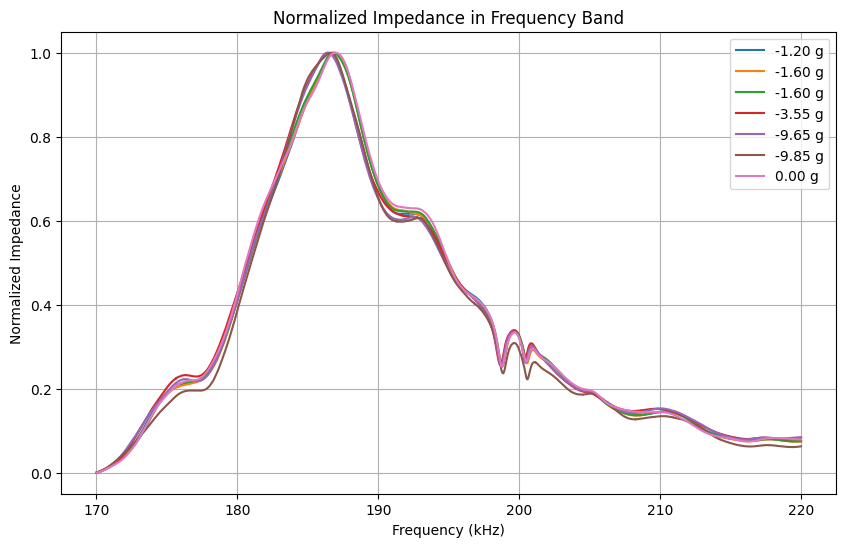

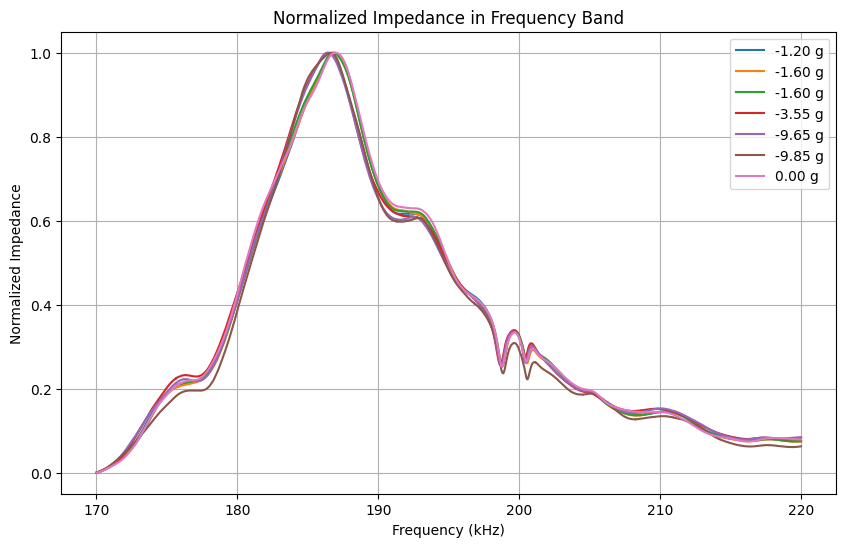

In [184]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

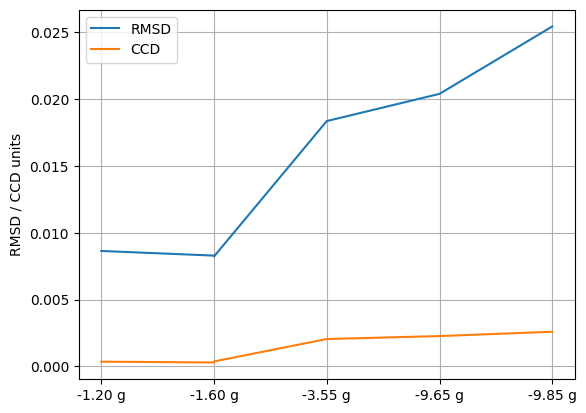

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot all except the last value which is the original, healthy dataset
ax1.plot(labels[:-1], rmsd_values[:-1], label='RMSD')
ax1.plot(labels[:-1],CCD_values[:-1], label='CCD')
ax1.set_ylabel('RMSD / CCD units')
ax1.legend(loc='upper left')
ax1.set_xlabel('Delta weight (Grams)')
plt.grid()
plt.show()


# Estimate Q factor

In [ ]:
import numpy as np

# Assume f_band and Z_meas_band.real are numpy arrays

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Impedance (ohms)"].values



def estimate_q_factor(f_band, Z_real):
    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)
    
    # Find lower frequency at half power
    lower_idx = np.where(Z_real[:peak_idx] <= half_power)[0]
    if len(lower_idx) == 0:
        f1 = f_band[0]
    else:
        f1 = f_band[lower_idx[-1]]
    
    # Find higher frequency at half power
    upper_idx = np.where(Z_real[peak_idx:] <= half_power)[0]
    if len(upper_idx) == 0:
        f2 = f_band[-1]
    else:
        f2 = f_band[peak_idx + upper_idx[0]]
    
    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf
    
    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")
    return Q

estimate_q_factor(df["Frequency (Hz)"]/1000, df["Impedance (ohms)"])



Resonant frequency f0 = 0.27 kHz
Bandwidth Δf = 0.02 kHz
Estimated Q factor = 15.36


np.float64(15.358863678940194)

Resonant frequency f0 = 186.97 kHz
Bandwidth Δf = 172.87 kHz
Estimated Q factor = 1.08


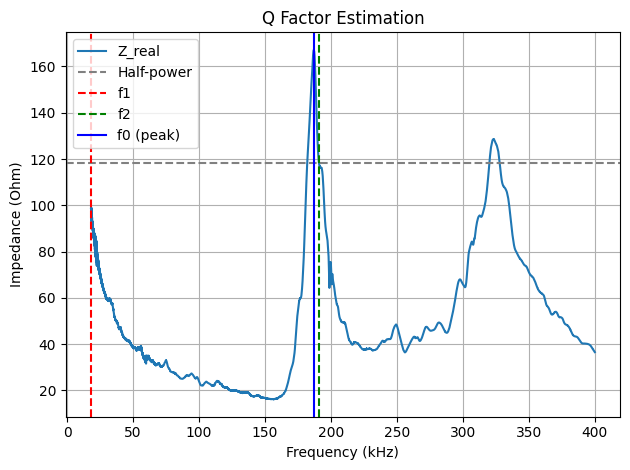

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#df = pd.read_csv("sample_1.csv", encoding="utf-8-sig")
#df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

f_band = df.iloc[:, 0].values  # First column: frequencies
Z_real = df.iloc[:, 1].values  # Second column: real part of impedance


def estimate_q_factor(f_band, Z_real, plot=False):
    f_band = np.array(f_band)
    Z_real = np.array(Z_real)

    peak_idx = np.argmax(Z_real)
    f0 = f_band[peak_idx]
    peak_val = Z_real[peak_idx]
    half_power = peak_val / np.sqrt(2)

    # Interpolation function
    interp = interp1d(f_band, Z_real, kind='cubic', bounds_error=False, fill_value="extrapolate")

    # Find lower half-power point
    lower_freqs = f_band[:peak_idx]
    lower_vals = Z_real[:peak_idx]
    f1 = f_band[0]
    for i in reversed(range(1, len(lower_vals))):
        if lower_vals[i] < half_power and lower_vals[i-1] > half_power:
            f1 = interp1d(lower_vals[i-1:i+1], lower_freqs[i-1:i+1])(half_power)
            break

    # Find upper half-power point
    upper_freqs = f_band[peak_idx:]
    upper_vals = Z_real[peak_idx:]
    f2 = f_band[-1]
    for i in range(1, len(upper_vals)):
        if upper_vals[i] < half_power and upper_vals[i-1] > half_power:
            f2 = interp1d(upper_vals[i-1:i+1], upper_freqs[i-1:i+1])(half_power)
            break

    bandwidth = f2 - f1
    Q = f0 / bandwidth if bandwidth != 0 else np.inf

    print(f"Resonant frequency f0 = {f0/1e3:.2f} kHz")
    print(f"Bandwidth Δf = {bandwidth/1e3:.2f} kHz")
    print(f"Estimated Q factor = {Q:.2f}")

    if plot:
        plt.figure()
        plt.plot(f_band / 1e3, Z_real, label='Z_real')
        plt.axhline(half_power, color='gray', linestyle='--', label='Half-power')
        plt.axvline(f1 / 1e3, color='red', linestyle='--', label='f1')
        plt.axvline(f2 / 1e3, color='green', linestyle='--', label='f2')
        plt.axvline(f0 / 1e3, color='blue', linestyle='-', label='f0 (peak)')
        plt.xlabel("Frequency (kHz)")
        plt.ylabel("Impedance (Ohm)")
        plt.title("Q Factor Estimation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return Q

Q = estimate_q_factor(f_band, Z_real, plot=True)


In [ ]:
print(combined_data["Frequency (Hz)"])

0          18000.0000
1          18010.0125
2          18020.0250
3          18030.0375
4          18040.0500
             ...     
801250    399976.5875
801251    399986.6000
801252    399996.6125
801253    400006.6250
801254    400016.6375
Name: Frequency (Hz), Length: 801255, dtype: float64


# Parameter estimation

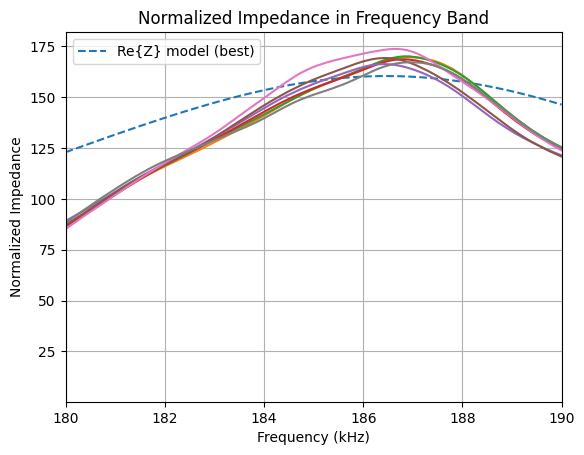

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

def mechanical_params_from_electrical(f, R1, L1, C1, C0):
    b1 = R1
    m1 = L1
    k1 = 1 / C1 if C1 != 0 else float('inf')  # Avoid division by zero
    k0 = 1 / C0 if C0 != 0 else float('inf')
    
    return {'b1': b1, 'm1': m1, 'k1': k1, 'k0': k0}

sample4 = combined_data[combined_data["sample_file"] == "sample_4.csv"]
f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Impedance (ohms)"].values

f_band = np.array(np.linspace(150000, 230000, 50000))

# --- Initial guesses (from you) ---
R1 = 130.0        # Ohms
L1 = 900e-6       # H
C1 = 0.93e-9      # F
C0 = 5.9e-9       # F

# --- Naive nested loops ---
Z_fit = model_Z(f_band, R1, L1, C1, C0)
# --- Plot ---
plt.figure()
plt.plot(f_band/1000, Z_fit.real, '--', label="Re{Z} model (best)")


f_min = min(f_band)
f_max = max(f_band)
freqs = dfs_for_sample[0]["Frequency (Hz)"].values
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_kHz = freqs[mask] / 1000
for i, df in enumerate(dfs_for_sample):
    Z = (df["Impedance (ohms)"].values[mask])
    plt.plot(freqs_kHz, Z)


plt.xlabel("Frequency (kHz)")
plt.ylabel("Normalized Impedance")
plt.title("Normalized Impedance in Frequency Band")
plt.grid(True)
plt.legend()
plt.xlim(180, 190)
plt.show()

# Peak analysis

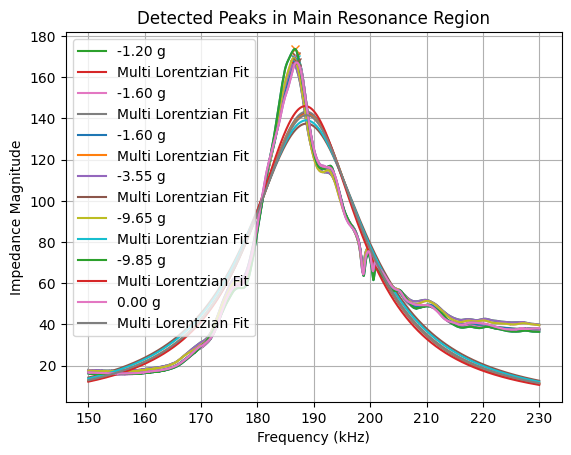

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

def lorentzian(f, A, f0, gamma):
    return A / (1 + ((f - f0) / gamma)**2)

def multi_lorentzian(f, *params):
    # params = [A1, f01, gamma1, A2, f02, gamma2, ...]
    n_peaks = len(params) // 3
    y = np.zeros_like(f)
    for i in range(n_peaks):
        A = params[3*i]
        f0 = params[3*i + 1]
        gamma = params[3*i + 2]
        y += lorentzian(f, A, f0, gamma)
    return y

# Frequency band in kHz
freqs = dfs_for_sample[0]["Frequency (Hz)"].values / 1000
f_min, f_max = 150, 230
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_band = freqs[mask]
i = 0
allPeaks = []
for df in dfs_for_sample:

    # Use first sample to detect peaks
    Z_mag = np.abs(df["Impedance (ohms)"].values[mask])

    # Find peaks (tweak parameters as needed)
    peaks, _ = find_peaks(Z_mag, height=np.max(Z_mag)*1, distance=100)

    allPeaks.append(peaks)

    plt.plot(freqs_band, Z_mag)
    plt.plot(freqs_band[peaks], Z_mag[peaks], "x")
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Impedance Magnitude")
    plt.title("Detected Peaks in Main Resonance Region")

    # Initial guess for parameters for 2 peaks as example
    initial_guess = []
    for p in peaks[:2]:  # Pick first 2 peaks for fit
        initial_guess += [Z_mag[p], freqs_band[p], 0.5]  # amplitude, center freq, width

    # Fit function for the first sample data
    popt, _ = curve_fit(multi_lorentzian, freqs_band, Z_mag, p0=initial_guess,maxfev=14000)

    # Plot fit
    plt.plot(freqs_band, Z_mag, label=labels[i])
    plt.plot(freqs_band, multi_lorentzian(freqs_band, *popt), label="Multi Lorentzian Fit")
    plt.legend()
    plt.grid(True)
    #plt.show()
    i +=1

    # You can now repeat the fitting for other samples and track popt parameters



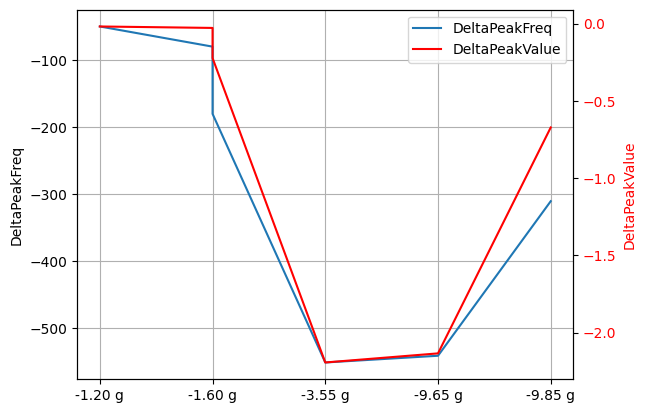

In [223]:
allPeaks = []
peakValues = []
freqs = dfs_for_sample[0]["Frequency (Hz)"].values / 1000
f_min, f_max = 150, 230
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_band = freqs[mask]*1000
i = 0

for df in dfs_for_sample:

    # Use first sample to detect peaks
    Z_mag = np.abs(df["Impedance (ohms)"].values[mask])

    # Find peaks (tweak parameters as needed)
    peaks, _ = find_peaks(Z_mag, height=np.max(Z_mag)*1, distance=100)

    allPeaks.append(peaks)
    peakValues.append(Z_mag)


DeltaPeakFreq = freqs_band[allPeaks] - freqs_band[allPeaks[6]]
DeltaPeakValue = Z_mag[allPeaks] - Z_mag[allPeaks[6]]


fig, ax1 = plt.subplots()

# Plot DeltaPeakFreq on the left axis
ax1.plot(labels[:-1], DeltaPeakFreq[:-1], label="DeltaPeakFreq")
ax1.set_ylabel("DeltaPeakFreq")
ax1.grid(True)

# Create second axis for DeltaPeakValue
ax2 = ax1.twinx()
ax2.plot(labels[:-1], DeltaPeakValue[:-1], color='r', label="DeltaPeakValue")
ax2.set_ylabel("DeltaPeakValue", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.show()


Measured % change: [-0.02251133 -0.0300151  -0.0300151  -0.06659601 -0.18102858 -0.18478047
  0.        ]
Predicted % change: [[-0.02169437]
 [-0.03295217]
 [-0.26627906]
 [-2.62400612]
 [-2.55356733]
 [-0.80385469]
 [ 0.        ]]


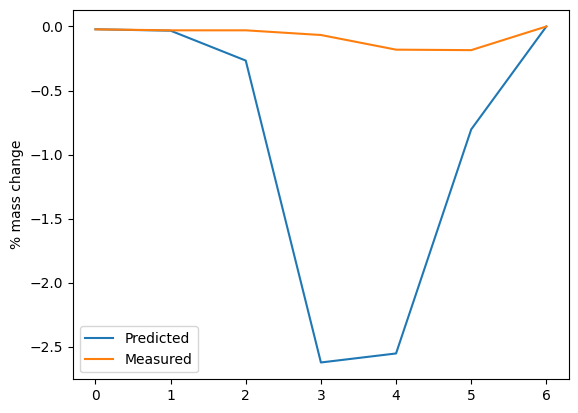

In [240]:
import numpy as np
import matplotlib.pyplot as plt

m0 = 5330.65  # initial mass in grams

# Convert labels to Δm in grams
labels_num = np.array([float(s.replace(' g', '')) for s in labels])

# Measured % change
measured_pct = (labels_num / m0) * 100

# Predicted Δm from impedance shift formula
deltaM = -2 * (-DeltaPeakValue / Z_mag[allPeaks[6]]) * m0  # in grams
predicted_pct = (deltaM / m0) * 100

# Compare
print("Measured % change:", measured_pct)
print("Predicted % change:", predicted_pct)

plt.plot(predicted_pct, label="Predicted")
plt.plot(measured_pct, label="Measured")
plt.ylabel("% mass change")
plt.legend()
plt.show()


# Chatgpt


initial guess (m,g*k,c): [5.30000000e+03 5.23297243e+14 1.66537545e+07] f0_est(Hz): 50009.95
fit success: True `ftol` termination condition is satisfied.
params: [3.95895629e-07 1.00456438e+07 6.82227554e+02] ± [2.35696934e-03 3.56649282e+08 1.50631376e+00]
initial guess (m,g*k,c): [5.30000000e+03 5.23297243e+14 1.66537545e+07] f0_est(Hz): 50009.95
fit success: True `ftol` termination condition is satisfied.
params: [4.11873951e-07 1.01128964e+07 6.86296695e+02] ± [2.37066384e-03 3.58721491e+08 1.51506576e+00]


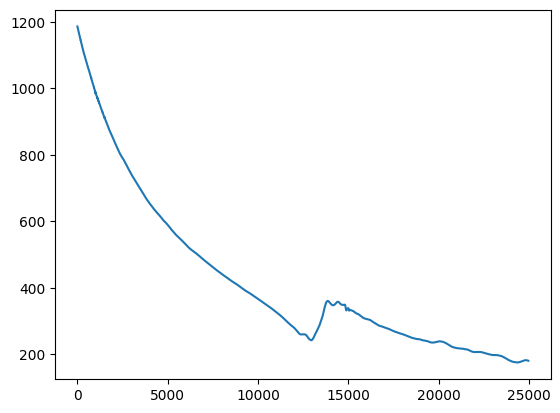

In [367]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

def z_model(params, omega):
    m, k, c = params
    return c + 1j*(omega*m - k/omega)

def residuals_complex(params, omega, Z_meas, weight=None):
    Zm = z_model(params, omega)
    res = Zm - Z_meas
    # stack real and imag so least_squares treats them as real residuals
    r = np.concatenate([np.real(res), np.imag(res)])
    if weight is not None:
        r = r * np.repeat(weight, 2)  # same weight for real & imag
    return r

def initial_guess_from_data(freq, Z, m0_guess=None):
    # freq in Hz, Z complex
    # guess f0 from max |Z|
    idx_peak = np.argmax(np.abs(Z))
    f0 = freq[idx_peak]
    omega0 = 2*np.pi*f0
    # rough estimate for mass using high-frequency slope of imag(Z) if available
    # fallback to provided m0_guess or 1.0
    if m0_guess is None:
        # estimate slope d(Im(Z))/d(omega) at high freq
        omegas = 2*np.pi*freq
        im = np.imag(Z)
        # pick upper 1/3 of data for slope estimate if available
        n = len(omegas)
        slice_idx = slice(int(2*n/3), n)
        try:
            slope = np.polyfit(omegas[slice_idx], im[slice_idx], 1)[0]
            m_guess = slope  # since Im(Z) ~ omega*m at high freq
            if m_guess <= 0:
                m_guess = 1.0
        except Exception:
            m_guess = 1.0
    else:
        m_guess = m0_guess

    # stiffness from k = m * omega0^2
    k_guess = m_guess * omega0**2

    # damping estimate from peak sharpness: use half-power bandwidth
    # estimate bandwidth from magnitude -3 dB points if possible
    mag = np.abs(Z)
    mag_peak = mag[idx_peak]
    half_power = mag_peak / np.sqrt(2)
    # find indices around peak crossing half power
    left = np.where(mag[:idx_peak] <= half_power)[0]
    right = np.where(mag[idx_peak:] <= half_power)[0]
    if left.size and right.size:
        f_left = freq[left[-1]]
        f_right = freq[idx_peak + right[0]]
        bw = f_right - f_left
        zeta = bw / (2*f0)
        c_guess = 2 * m_guess * (2*np.pi*f0) * zeta
    else:
        c_guess = 0.01 * m_guess * omega0  # small default

    return np.array([m_guess, k_guess, c_guess]), f0

def fit_sdof(freq, Z_meas, m0_guess=None, freq_window=None, weight=None, verbose=False):
    # freq in Hz; convert to omega
    freq = np.asarray(freq)
    omegas = 2*np.pi*freq
    Z_meas = np.asarray(Z_meas, dtype=complex)

    # optionally restrict to window around resonance
    if freq_window is not None:
        fcenter, fw = freq_window
        mask = (freq >= (fcenter - fw)) & (freq <= (fcenter + fw))
        omegas_fit = omegas[mask]
        Z_fit = Z_meas[mask]
        freq_fit = freq[mask]
    else:
        omegas_fit = omegas
        Z_fit = Z_meas
        freq_fit = freq

    p0, f0_est = initial_guess_from_data(freq_fit, Z_fit, m0_guess)

    if verbose:
        print("initial guess (m,g*k,c):", p0, "f0_est(Hz):", f0_est)

    # weight: prefer frequencies near resonance (optional)
    if weight is None:
        # example: gaussian weighting centered at f0_est
        sigma = (freq_fit.max() - freq_fit.min())/6.0
        weight_vec = np.exp(-0.5*((freq_fit - f0_est)/sigma)**2)
    else:
        weight_vec = weight

    res = least_squares(residuals_complex, p0, args=(omegas_fit, Z_fit, weight_vec),
                        method='lm', max_nfev=20000)

    # estimate covariance from Jacobian (approx)
    # Jacobian is  (2N x 3), compute cov = inv(J^T J) * residual_variance
    J = res.jac
    dof = J.shape[0] - len(res.x)
    try:
        JTJ = J.T.dot(J)
        cov = np.linalg.inv(JTJ) * (2*np.sum(res.fun**2) / (J.shape[0]))  # scaled
        perr = np.sqrt(np.abs(np.diag(cov)))
    except np.linalg.LinAlgError:
        cov = None
        perr = np.full_like(res.x, np.nan)

    if verbose:
        print("fit success:", res.success, res.message)
        print("params:", res.x, "±", perr)

    return {
        'params': res.x,          # [m, k, c]
        'param_err': perr,
        'cov': cov,
        'f0_est': f0_est,
        'res': res,
        'freq_fit': freq_fit,
        'Z_fit': Z_fit
    }

# ---------- Example usage ----------
# freq: 1D array in Hz
# if you have magnitude and phase (degrees):
# Z = Zmag * np.exp(1j * np.deg2rad(phase))

allPeaks = []
peakValues = []
freqs = dfs_for_sample[0]["Frequency (Hz)"].values / 1000
f_min, f_max = 50, 300
mask = (freqs >= f_min) & (freqs <= f_max)
freqs_band = freqs[mask]*1000
i = 0

freq = freqs_band
allZ = []

for df in dfs_for_sample:

    # Use first sample to detect peaks
    Z_real = (df["Impedance (ohms)"].values[mask])
    Z_imag = (df["Phase (Radians)"].values[mask])

    Z_mag = np.sqrt(Z_real**2 + Z_imag**2)
    Z_phase = np.arctan2(Z_imag, Z_real)  # in radians
    Z = Z_mag * np.exp(1j * np.deg2rad(Z_phase))

    allZ.append(Z)

plt.plot(np.real(Z))

#
# Call this for before/after measurement and compare m:
#


fit_before = fit_sdof(freq, allZ[6], m0_guess=5300, verbose=True)
fit_after  = fit_sdof(freq,  allZ[1],  m0_guess=5300, verbose=True)

m0_reference = 5330.0

m_before = fit_before['params'][0]
m_after  = fit_after['params'][0]
delta_m = m_after - m_before

relative_pct_measured = (labels_num / m0_reference) * 100
predicted_pct = (delta_m / m0_reference) * 100

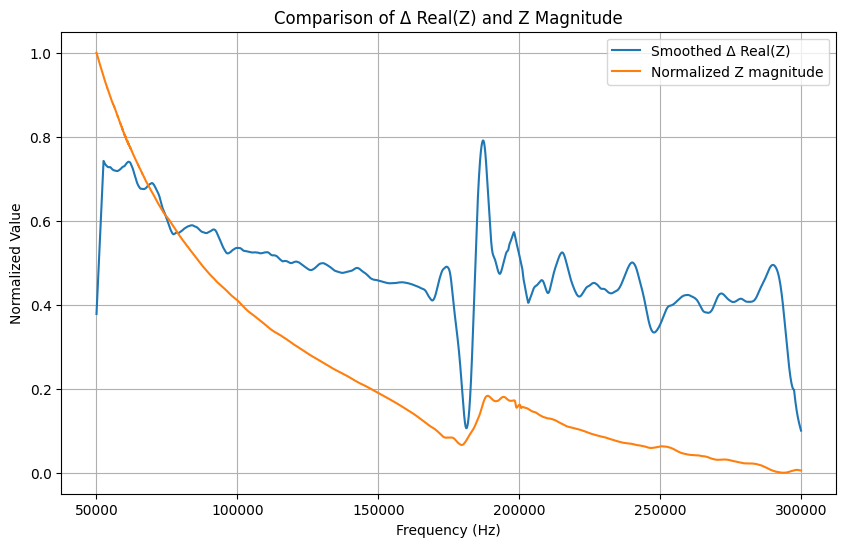

In [326]:
import matplotlib.pyplot as plt
import numpy as np

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

plt.figure(figsize=(10,6))

plt.plot(freq, np.convolve(normalize(np.real(allZ[5] - allZ[6])), np.ones(500)/500, mode='same'), label='Smoothed Δ Real(Z)')
plt.plot(freq, normalize(Z_mag), label='Normalized Z magnitude')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Value')
plt.title('Comparison of Δ Real(Z) and Z Magnitude')
plt.legend()
plt.grid(True)
plt.show()


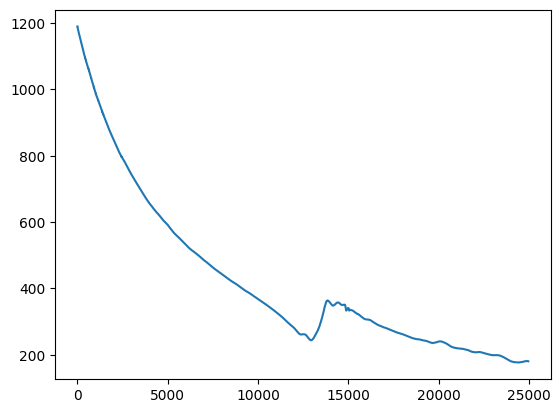

In [364]:
import numpy as np
import sounddevice as sd

# Extract the data you plotted
y = np.convolve(normalize(np.real(allZ[0])), np.ones(1)/1, mode='same')

# Normalize audio to -1..1 range
audio = y - np.mean(y)
audio /= np.max(np.abs(audio))

plt.plot(np.real(allZ[0]))

# Define playback sampling rate (Hz), e.g. 44100
fs = 44100

# Because freq vector may not correspond to audio sample rate, resample y to match fs length
from scipy.signal import resample
audio_resampled = resample(audio*1, fs)  # 1 second of audio

# Play sound (requires sounddevice package: pip install sounddevice)
sd.play(audio_resampled, fs)
sd.wait()


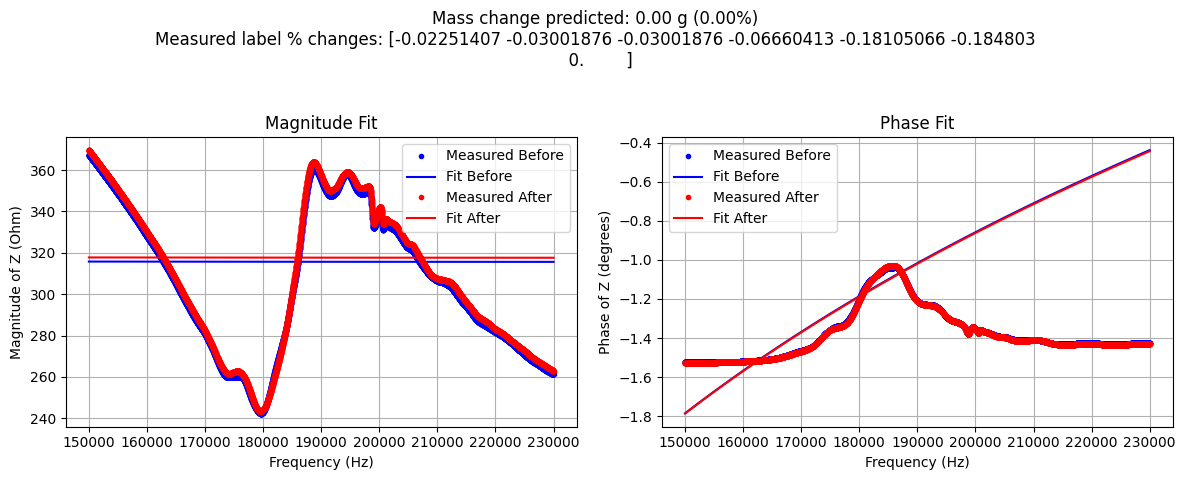

In [270]:
import matplotlib.pyplot as plt
import numpy as np

# Extract fitted parameters
m_b, k_b, c_b = fit_before['params']
m_a, k_a, c_a = fit_after['params']

# Compute model impedance over freq
omega = 2 * np.pi * freq
Z_fit_before = c_b + 1j*(omega*m_b - k_b/omega)
Z_fit_after = c_a + 1j*(omega*m_a - k_a/omega)

plt.figure(figsize=(12,5))

# Plot magnitude
plt.subplot(1,2,1)
plt.plot(freq, np.abs(allZ[6]), 'b.', label='Measured Before')
plt.plot(freq, np.abs(Z_fit_before), 'b-', label='Fit Before')
plt.plot(freq, np.abs(allZ[1]), 'r.', label='Measured After')
plt.plot(freq, np.abs(Z_fit_after), 'r-', label='Fit After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of Z (Ohm)')
plt.title('Magnitude Fit')
plt.legend()
plt.grid(True)

# Plot phase
plt.subplot(1,2,2)
plt.plot(freq, np.angle(allZ[6], deg=True), 'b.', label='Measured Before')
plt.plot(freq, np.angle(Z_fit_before, deg=True), 'b-', label='Fit Before')
plt.plot(freq, np.angle(allZ[1], deg=True), 'r.', label='Measured After')
plt.plot(freq, np.angle(Z_fit_after, deg=True), 'r-', label='Fit After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase of Z (degrees)')
plt.title('Phase Fit')
plt.legend()
plt.grid(True)

plt.suptitle(f'Mass change predicted: {delta_m:.2f} g ({predicted_pct:.2f}%)\nMeasured label % changes: {relative_pct_measured}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2-DOF

In [267]:
import numpy as np
from scipy.optimize import least_squares

def impedance_2dof(freq, params):
    """
    Calculate 2-DOF mechanical impedance.

    freq : array_like, frequencies (Hz)
    params : list or array [m1, k1, c1, m2, k2, c2]

    returns: complex impedance array
    """
    m1, k1, c1, m2, k2, c2 = params
    omega = 2 * np.pi * freq + 1e-12  # avoid division by zero

    Z1 = c1 + 1j * omega * m1 - k1 / (1j * omega)
    Z2 = c2 + 1j * omega * m2 - k2 / (1j * omega)

    # Two impedances in series: Z_total = Z1 + Z2
    Z_total = Z1 + Z2

    return Z_total

def residuals(params, freq, Z_meas):
    Z_pred = impedance_2dof(freq, params)
    return np.concatenate([(Z_pred.real - Z_meas.real), (Z_pred.imag - Z_meas.imag)])

def fit_2dof(freq, Z_meas, initial_guess=None, verbose=False):
    if initial_guess is None:
        initial_guess = [5300, 1e6, 1000, 1000, 1e6, 1000]  # rough guess [m1,k1,c1,m2,k2,c2]

    res = least_squares(residuals, initial_guess, args=(freq, Z_meas), verbose=2 if verbose else 0)

    if verbose:
        print("Fit parameters (m1, k1, c1, m2, k2, c2):", res.x)

    return {'params': res.x, 'success': res.success, 'cost': res.cost}


fit_result = fit_2dof(freq, allZ[6], verbose=True)

params = fit_result['params']
print("Fitted parameters:", params)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2931e+23                                    7.28e+19    
       1              2         1.7922e+23      5.01e+22       1.41e+06       6.44e+19    
       2              3         2.5512e+11      1.79e+23       2.83e+06       7.68e+13    
       3              4         4.8719e+06      2.55e+11       5.66e+06       1.15e+07    
       4              5         4.8716e+06      2.74e+02       1.13e+07       1.64e+07    
       5              6         4.8714e+06      1.94e+02       2.26e+07       1.71e+06    
       6              7         4.8712e+06      2.45e+02       4.53e+07       2.09e+07    
       7              8         4.8710e+06      2.05e+02       9.05e+07       2.53e+07    
       8              9         4.8708e+06      2.18e+02       1.81e+08       2.14e+07    
       9             10         4.8706e+06      1.93e+02       3.62e+08       3.07e+07    

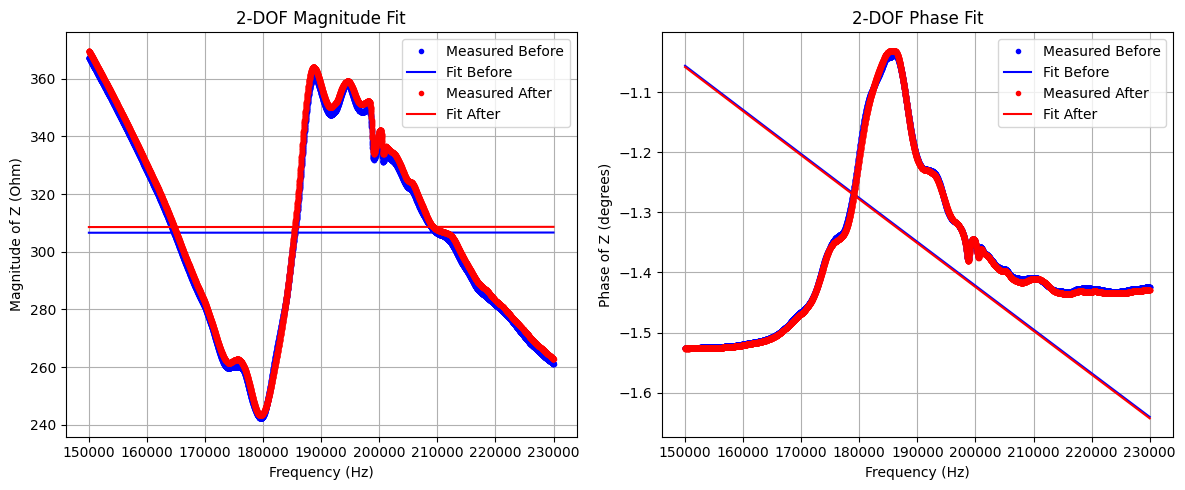

In [268]:
import matplotlib.pyplot as plt
import numpy as np

params_before = fit_2dof(freq, allZ[6], verbose=False)['params']
params_after  = fit_2dof(freq, allZ[1], verbose=False)['params']

Z_fit_before = impedance_2dof(freq, params_before)
Z_fit_after  = impedance_2dof(freq, params_after)

plt.figure(figsize=(12,5))

# Magnitude plot
plt.subplot(1,2,1)
plt.plot(freq, np.abs(allZ[6]), 'b.', label='Measured Before')
plt.plot(freq, np.abs(Z_fit_before), 'b-', label='Fit Before')
plt.plot(freq, np.abs(allZ[1]), 'r.', label='Measured After')
plt.plot(freq, np.abs(Z_fit_after), 'r-', label='Fit After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of Z (Ohm)')
plt.title('2-DOF Magnitude Fit')
plt.legend()
plt.grid(True)

# Phase plot
plt.subplot(1,2,2)
plt.plot(freq, np.angle(allZ[6], deg=True), 'b.', label='Measured Before')
plt.plot(freq, np.angle(Z_fit_before, deg=True), 'b-', label='Fit Before')
plt.plot(freq, np.angle(allZ[1], deg=True), 'r.', label='Measured After')
plt.plot(freq, np.angle(Z_fit_after, deg=True), 'r-', label='Fit After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase of Z (degrees)')
plt.title('2-DOF Phase Fit')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Brute force search

Best MSE: 707.7586997210116
Best parameters:
  R1 = 201.5 Ohm
  L1 = 0.0009 H
  C1 = 8.9e-10 F
  C0 = 5.31e-09 F


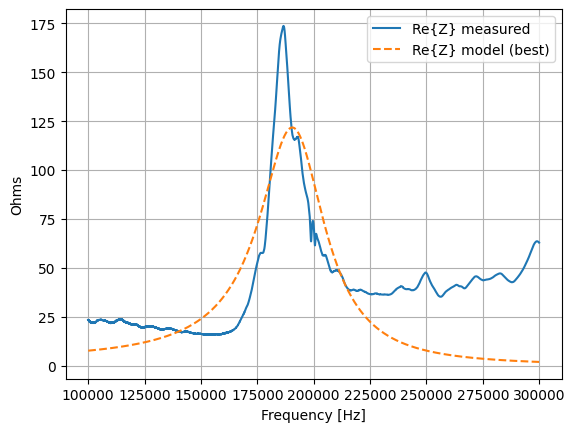

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

# --- Search grids (very simple, coarse) ---
R1_grid = np.linspace(R1_0*0.5, R1_0*1.5, 21)          # 21 points
L1_grid = np.linspace(L1_0*0.5, L1_0*1.5, 21)
C1_grid = np.linspace(C1_0*0.5, C1_0*1.5, 21)
C0_grid = np.linspace(C0_0*0.5, C0_0*1.5, 21)

best_mse = np.inf
best_params = (R1_0, L1_0, C1_0, C0_0)
best_fit = None

# --- Naive nested loops ---
for R1 in R1_grid:
    for L1 in L1_grid:
        for C1 in C1_grid:
            for C0 in C0_grid:
                Z_fit = model_Z(f_band, R1, L1, C1, C0)
                mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (R1, L1, C1, C0)
                    best_fit = Z_fit

print("Best MSE:", best_mse)
print("Best parameters:")
print(f"  R1 = {best_params[0]:.6g} Ohm")
print(f"  L1 = {best_params[1]:.6g} H")
print(f"  C1 = {best_params[2]:.6g} F")
print(f"  C0 = {best_params[3]:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


# Dmg state

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Initial guesses (from you) ---
R1_0 = 155.0        # Ohms
L1_0 = 900e-6       # H
C1_0 = 0.89e-9      # F
C0_0 = 5.9e-9       # F

# --- Model ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)   # series RLC
    Y_total = 1j*w*C0 + 1/Zs          # parallel C0
    return 1 / Y_total

# --- Search grids (very simple, coarse) ---
R1_grid = np.linspace(R1_0*0.5, R1_0*1.5, 21)          # 21 points
L1_grid = np.linspace(L1_0*0.5, L1_0*1.5, 21)
C1_grid = np.linspace(C1_0*0.5, C1_0*1.5, 21)
C0_grid = np.linspace(C0_0*0.5, C0_0*1.5, 21)

best_mse = np.inf
best_params = (R1_0, L1_0, C1_0, C0_0)
best_fit = None

# --- Naive nested loops ---
for R1 in R1_grid:
    for L1 in L1_grid:
        for C1 in C1_grid:
            for C0 in C0_grid:
                Z_fit = model_Z(f_band, R1, L1, C1, C0)
                mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (R1, L1, C1, C0)
                    best_fit = Z_fit

print("Best MSE:", best_mse)
print("Best parameters:")
print(f"  R1 = {best_params[0]:.6g} Ohm")
print(f"  L1 = {best_params[1]:.6g} H")
print(f"  C1 = {best_params[2]:.6g} F")
print(f"  C0 = {best_params[3]:.6g} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()



KeyboardInterrupt: 

# New plotting

Best MSE: 725.6676121070736
Best C1: 8.990816326530612e-10 F


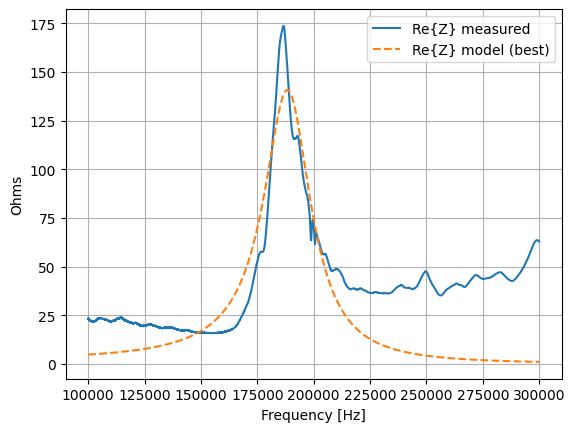

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}

# --- Model function ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y_total = 1j*w*C0 + 1/Zs
    return 1 / Y_total

# --- Optimizer function ---
def optimize_single_param(f_band, Z_meas_band, param_name, num_points=50, scale=0.5):
    if param_name not in param_guesses:
        raise ValueError(f"Invalid parameter: {param_name}")

    # Get initial values
    base_params = param_guesses.copy()
    base_value = base_params[param_name]
    
    # Create grid for the selected parameter
    param_grid = np.linspace(base_value * (1 - scale), base_value * (1 + scale), num_points)

    best_mse = np.inf
    best_value = base_value

    for val in param_grid:
        params = base_params.copy()
        params[param_name] = val
        Z_fit = model_Z(f_band, **params)
        mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
        if mse < best_mse:
            best_mse = mse
            best_value = val

    return best_mse, best_value


# Example usage:
best_mse, best_C1 = optimize_single_param(f_band, Z_meas_band, 'C1')
print(f"Best MSE: {best_mse}")
print(f"Best C1: {best_C1} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}

# --- Model function ---
def model_Z(f, R1, L1, C1, C0):
    w = 2 * np.pi * f
    Zs = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y_total = 1j*w*C0 + 1/Zs
    return 1 / Y_total

# --- Optimizer function ---
def optimize_single_param(f_band, Z_meas_band, param_name, num_points=50, scale=0.5):
    if param_name not in param_guesses:
        raise ValueError(f"Invalid parameter: {param_name}")

    # Get initial values
    base_params = param_guesses.copy()
    base_value = base_params[param_name]
    
    # Create grid for the selected parameter
    param_grid = np.linspace(base_value * (1 - scale), base_value * (1 + scale), num_points)

    best_mse = np.inf
    best_value = base_value

    for val in param_grid:
        params = base_params.copy()
        params[param_name] = val
        Z_fit = model_Z(f_band, **params)
        mse = mean_squared_error(Z_meas_band.real, Z_fit.real)
        if mse < best_mse:
            best_mse = mse
            best_value = val

    return best_mse, best_value


# Example usage:
best_mse, best_C1 = optimize_single_param(f_band, Z_meas_band, 'C1')
print(f"Best MSE: {best_mse}")
print(f"Best C1: {best_C1} F")

# --- Plot ---
plt.figure()
plt.plot(f_band, Z_meas_band.real, label="Re{Z} measured")
plt.plot(f_band, best_fit.real, '--', label="Re{Z} model (best)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Ohms")
plt.legend()
plt.grid(True)
plt.show()
